6/23/2018

# P&S applied to New York 311 Call Complaint Data.
This notebook plotss feature importaance from fitted RF model on random 80-20 train/test split and also plots one tree from fitted model. These figures correspond with the appendix figures.

In [17]:
from __future__ import division
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


execfile('../functions/python_libraries.py')
execfile('../functions/simulation_functions.py')

ny_df = pd.read_csv('../../../NY/CleanData.csv')

ny_df_subset = ny_df[['BORO', 'SCORE', 'complaint','Asian','subsequentScore', 'avg.score']]


ny_df_subset.reset_index(inplace=True, drop=True)

ny_df_subset.columns = ['BORO_SAP', 'score_SAP', 'complaint_CP',
                        'asian_SUP','y','avg_score_SAP']#, 'non_chinese_SUP']



ny_df_subset.BORO_SAP = map(str,ny_df_subset.BORO_SAP)
ny_df_subset = ny_df_subset.loc[~ny_df_subset.y.isnull()]
ny_df_subset = ny_df_subset.loc[ny_df_subset.y != -1]

## try one-hop encoding CAMIS and year_SAP; unclear how RF is handling these categorical features
zip_SAP = pd.get_dummies(ny_df_subset.BORO_SAP)

## subset to only 4-columns -- (i.e. K-1 for K categories)
#years_SAP = years_SAP[[u'BROOKLYN', u'MANHATTAN', u'QUEENS', u'STATEN ISLAND']]

zip_SAP.columns = np.array(zip_SAP.columns) + '_SAP'
print np.shape(zip_SAP)
ny_df_subset_RF = pd.concat((ny_df_subset,zip_SAP), axis = 1)
SAP_cols_RF = [s for s in np.array(ny_df_subset_RF.columns) if "SAP" in s]
CP_cols_RF = ['complaint_CP']

zip_SAP = pd.get_dummies(ny_df_subset.BORO_SAP)
zip_SAP = zip_SAP[np.array(zip_SAP.columns)[0:len(np.array(zip_SAP.columns))-1]]
zip_SAP.columns = np.array(zip_SAP.columns) + '_SAP'
ny_df_subset_OLS = pd.concat((ny_df_subset,zip_SAP), axis = 1)
SAP_cols_OLS = [s for s in np.array(ny_df_subset_OLS.columns) if "SAP" in s]
CP_cols_OLS= ['complaint_CP']


ny_df_subset_RF.drop(['BORO_SAP'], inplace = True, axis = 1)
ny_df_subset_OLS.drop(['BORO_SAP'], inplace = True, axis = 1)



SAP_cols_OLS = [s for s in np.array(ny_df_subset_OLS.columns) if "SAP" in s]
SAP_cols_RF = [s for s in np.array(ny_df_subset_RF.columns) if "SAP" in s]


ny_df_subset_RF.drop_duplicates(inplace = True)
ny_df_subset_OLS.drop_duplicates(inplace = True)
ny_df_subset_RF.y = map(np.int,ny_df_subset_RF.y)
ny_df_subset_OLS.y = map(np.int,ny_df_subset_OLS.y)


(51470, 5)


# One Train/Test Split for RF Model

In [18]:
clf = sklearn.ensemble.RandomForestRegressor()
max_depth = [3, 5, 10]
max_depth.append(None) 
min_samples_leaf = [5, 10, 20, 50, 100]
min_samples_split = [2, 3, 4, 5, 10] 
n_estimators = [50, 100, 150] #[10, 50, 100, 150, 200]
max_features = ['auto', 0.25, 0.5, 0.75] 
random_grid = {'max_depth': max_depth,
            'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'n_estimators': n_estimators,
              'min_samples_split': min_samples_split}

model = GridSearchCV(estimator = clf,
                param_grid = random_grid,
                cv = 3, verbose=0,
                n_jobs = -1)

In [19]:
import sklearn.cross_validation
k_fold = sklearn.cross_validation.ShuffleSplit(len(ny_df_subset_RF.y), n_iter=1,
                                                         test_size=0.2,
                                                         random_state=0)

for k, (train, test) in enumerate(k_fold):
    print k
    df_subset_train = ny_df_subset_RF.iloc[train,:]
    df_subset_test = ny_df_subset_RF.iloc[test,:]


0


# Justify Hyperparameter Grid Range

In [20]:
## Hyperparamter Search set-up
clf = sklearn.ensemble.RandomForestRegressor()
max_depth = [3, 5, 10]
max_depth.append(None) 
min_samples_leaf = [5, 10, 20, 50, 100]
min_samples_split = [2, 3, 4, 5, 10] 
n_estimators = [50, 100, 150] #[10, 50, 100, 150, 200]
max_features = ['auto', 0.25, 0.5, 0.75] 
random_grid = {'max_depth': max_depth,
            'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'n_estimators': n_estimators,
              'min_samples_split': min_samples_split}

model = GridSearchCV(estimator = clf,
                param_grid = random_grid,
                cv = 3, verbose=0,
                n_jobs = -1)

In [21]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
from collections import OrderedDict
RANDOM_STATE = 123

ensemble_clfs = [
    ("RF, max_depth=3",
        sklearn.ensemble.RandomForestRegressor(warm_start=True, oob_score=True,max_depth = 3,
                               max_features='auto',
                               random_state=RANDOM_STATE)),
    ("RF, max_depth=5",
        sklearn.ensemble.RandomForestRegressor(warm_start=True, max_features='auto',max_depth = 5,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RF, max_depth=10",
        sklearn.ensemble.RandomForestRegressor(warm_start=True, max_features='auto',max_depth = 10,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)



# Range of `n_estimators` values to explore.
min_estimators = 5
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        #print i
        clf.set_params(n_estimators=i)
        clf.fit(df_subset_train[sum([SAP_cols_RF, CP_cols_RF, ['asian_SUP']], [])], 
                    df_subset_train.y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))



In [22]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
    plt.scatter(xs, ys)#, label=label)

plt.axvline(50, color = 'gray', alpha = 0.5, ls = '--')
plt.axvline(150, color = 'gray', alpha = 0.5, ls = '--')


plt.xlim(min_estimators, max_estimators)
#plt.ylim(0.88, 0.96)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title('New York (n_estimators)')
#plt.legend(loc="upper right")

plt.tight_layout()
pp = PdfPages("./figs/NY_n_estimators_all_other_parameters_default.pdf")
pp.savefig()
pp.close()

# Feature Importance

In [23]:
model.fit(df_subset_train[sum([SAP_cols_RF, CP_cols_RF, ['asian_SUP']], [])], 
                    df_subset_train.y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': ['auto', 0.25, 0.5, 0.75], 'n_estimators': [50, 100, 150], 'min_samples_split': [2, 3, 4, 5, 10], 'max_depth': [3, 5, 10, None], 'min_samples_leaf': [5, 10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
print sum([SAP_cols_RF, CP_cols_RF, ['asian_SUP']], [])

['score_SAP', 'avg_score_SAP', 'BRONX_SAP', 'BROOKLYN_SAP', 'MANHATTAN_SAP', 'QUEENS_SAP', 'STATEN ISLAND_SAP', 'complaint_CP', 'asian_SUP']


In [25]:
imp = model.best_estimator_.feature_importances_

## here is to rename for figure formatting -- needs to be in same order as above printed
names = ['prior score',
            'avg. prior score',                     
                        'Bronx',
                        'Brooklyn',
                        'Manhattan',
                        'Queens',
                        'Staten Island',
                        'complaints',
                        'is Asian']

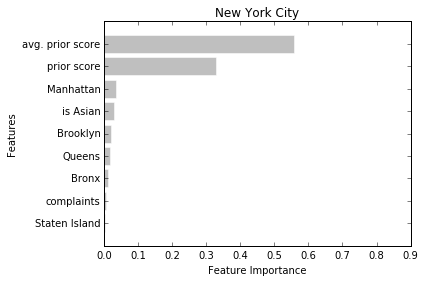

In [26]:
imp, names = zip(*sorted(zip(imp,names)))

%matplotlib inline
plt.barh(range(len(names)), imp, align = 'center', alpha = 0.5, edgecolor='white', color = 'gray')
plt.yticks(range(len(names)), names)
plt.xlabel('Feature Importance')
plt.title('New York City')
plt.ylabel('Features')
plt.xlim(0,0.9)
plt.tight_layout()
pp = PdfPages('./figs/NY_feature_importance.pdf')
pp.savefig()
pp.close()

# Visualize Decision Tree from RF Model


In [31]:
tree_id = 89

In [32]:
%matplotlib inline

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model.best_estimator_.estimators_[tree_id], out_file=dot_data,  
                feature_names = ['past inspection',
                                 'avg. past inspection',
                        'in Bronx',
                        'in Brooklyn',
                        'in Manhattan',
                        'in Queens',
                        'in Staten_Island',
                        'complaint count',
                        'is Asian'],
                max_depth = 2,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
graph.write_pdf("./figs/NYC_DT_full_depth_2.pdf")



True

In [33]:
%matplotlib inline

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model.best_estimator_.estimators_[tree_id], out_file=dot_data,  
                feature_names = ['past inspection',
                                 'avg. past inspection',
                        'in Bronx',
                        'in Brooklyn',
                        'in Manhattan',
                        'in Queens',
                        'in Staten_Island',
                        'complaint count',
                        'is Asian'],
                max_depth = 3,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
graph.write_pdf("./figs/NYC_DT_full_depth_3.pdf")




True

In [34]:
%matplotlib inline

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model.best_estimator_.estimators_[tree_id], out_file=dot_data,  
                feature_names = ['past inspection',
                                 'avg. past inspection',
                                 
                        'in Bronx',
                        'in Brooklyn',
                        'in Manhattan',
                        'in Queens',
                        'in Staten_Island',
                        'complaint count',
                        'is Asian'],
                #max_depth = 4,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
graph.write_pdf("./figs/NYC_DT_full.pdf")





True